In [ ]:
%pip install uce-model
%pip install deepspeed
%pip install umap-pytorch
%pip install matplotlib

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import uce

In [14]:
model = uce.get_pretrained_model(size='small')  # Load the pre-trained model
model = model.to('cuda')

Loading small pretrained model with 4 layers...
Using sample 4 layer model


In [15]:
dataset, dataloader = uce.get_processed_dataset(batch_size=32)  # Get default dataset

Using sample AnnData: 10k pbmcs dataset
Using sample 4 layer model
10k_pbmcs_proc already processed. Skipping
PE Idx, Chrom and Starts files already created


In [18]:
import deepspeed
import torch
model = torch.compile(model)
# ds_engine = deepspeed.init_inference(torch.compile(model), fp16={'enabled': False})
# model: uce.model.TransformerModel = ds_engine.module

In [20]:
import torch
from tqdm.auto import trange
num_batches = len(dataloader)
all_embeddings = []
with torch.no_grad():
    for i, batch in zip(trange(num_batches), dataloader):
        batch_sentences, mask, idcs, _cell_sentences = batch
        # print(batch_sentences.device)
        batch_sentences = batch_sentences.to('cuda')
        batch_sentences = model.pe_embedding(batch_sentences.permute(1, 0).long())
        _, embeddings = model(batch_sentences, mask=mask.cuda())
        # print(embeddings.shape)
        all_embeddings.append(embeddings)
        # print(embeddings)
all_embeddings = torch.concatenate(all_embeddings, dim=0)

  0%|          | 0/375 [00:00<?, ?it/s]

In [22]:
print(all_embeddings.dtype)
print(all_embeddings.numel() * 4 / 1e6, 'MB')

torch.float32
61.3888 MB


In [23]:
from umap_pytorch import PUMAP
pumap = PUMAP(
    encoder=None,
    decoder=None
)

pumap.fit(all_embeddings.cpu())

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Mon Feb 19 14:40:11 2024 Building RP forest with 10 trees
Mon Feb 19 14:40:11 2024 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	 5  /  14
	 6  /  14
	Stopping threshold met -- exiting after 6 iterations


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type            | Params
--------------------------------------------
0 | encoder | default_encoder | 337 K 
--------------------------------------------
337 K     Trainable params
0         Non-trainable params
337 K     Total params
1.348     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [24]:
umap_embeddings = pumap.transform(all_embeddings.cpu().float())

Reducing array of shape torch.Size([11990, 1280]) to (11990, 2)


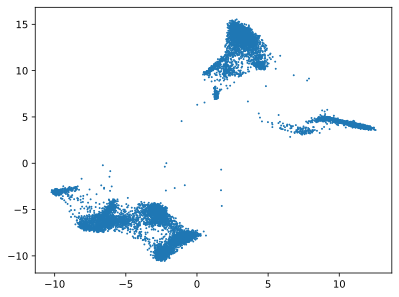

In [28]:
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], s=1)